In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesResampler
import scipy as sp
import scipy.signal
import os
import pandas as pd
from torch import nn
from scipy.spatial.distance import cdist
import spikeinterface.core as sc
import spikeinterface.full as si

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_gmm, plot_closest_spikes
from analysis.contrastive_utils import load_GPT_backbone
from analysis.cluster import GMM, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from analysis.cluster import MeanShift
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs
import matplotlib.patheffects as pe

from load_models import load_ckpt

from spike_psvae.denoise import SingleChanDenoiser

import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
ccolors = cc.glasbey[:31]

Failed to import IBL packages (brainbox, ibllib, one, brainbox


In [3]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [5]:
is_multi_chan = False
data_path_wavemap = Path('/moto/home/ch3676/WaveMAP_Paper/data/')
spikes_test_wavemap = np.load(data_path_wavemap / 'full_data.npy')

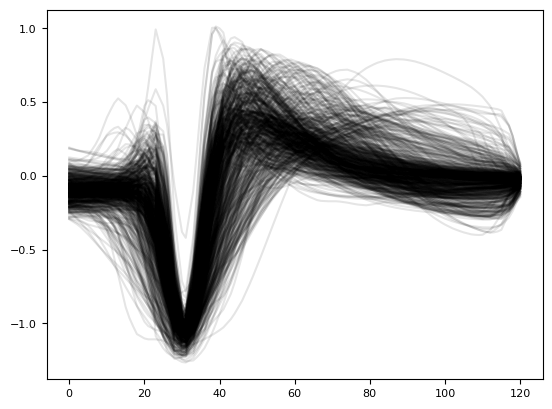

In [6]:
#upsample data for our model
spikes_test_wavemap_up = []
plot = True
for spike in spikes_test_wavemap:
    # plt.plot(spike, alpha=.1, color='black')
    spike_up = TimeSeriesResampler(sz=121).fit_transform(spike[None,:])
    spikes_test_wavemap_up.append(spike_up[0,:,0])
    if plot:
        plt.plot(spike_up[0,:,0], alpha=.1, color='black')
spikes_test_wavemap_up = np.asarray(spikes_test_wavemap_up)

In [7]:
# path_to = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/model_ckpts/dy016_single_cell_type_models/0514cellgoodout_dim128proj_dim5batch-size512lr0.001epochs800fp16use_gptis_causaln_embd32add_traindropout0.0cell_type/')
path_to = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/model_ckpts/dy016_single_cell_type_models/0514cellrandout_dim128proj_dim5batch-size512lr0.001epochs800fp16use_gptis_causaln_embd32add_traindropout0.0cell_type/')

In [49]:
train_reps = torch.load(path_to / 'train_aftproj_reps.pt', map_location='cpu').numpy()
test_reps = torch.load(path_to / 'test_aftproj_reps.pt', map_location='cpu').numpy()
train_labels = torch.load(path_to / 'l', map_location='cpu').numpy()
test_labels  = torch.load(path_to / 'test_aftproj_reps.pt', map_location='cpu').numpy()

In [ ]:
plt.scatter9)

In [9]:
#load checkpoint
path_to_checkpoint = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/model_ckpts/dy016_single_cell_type_models/0514cellrandout_dim128proj_dim5batch-size512lr0.001epochs800fp16use_gptis_causaln_embd32add_traindropout0.0cell_type/checkpoint.pth')

checkpoint_path = path_to_checkpoint / 'checkpoint.pth'

# load GPT backbone only
model = load_ckpt(path_to_checkpoint, multi_chan=is_multi_chan, rep_dim=128, 
                  pos_enc='conseq', rep_after_proj=True)

Using projector; batchnorm False with depth 3; hidden_dim=512
number of parameters: 0.58M
Using projector; batchnorm False with depth 3; hidden_dim=512
missing keys []
unexpected keys []


In [10]:
cont_reps = []
with torch.no_grad():
    for spike in spikes_test_wavemap_up:
        spike = torch.from_numpy(spike[None,:].astype('float32'))
        data = torch.unsqueeze(spike, dim=-1)
        feature = model(data)
        cont_reps.append(feature)
cont_reps = torch.concatenate(cont_reps).detach().squeeze().numpy()

In [11]:
N_NEIGHBORS = 20 

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.1

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
cont_reps_umap = learn_manifold_umap(cont_reps, umap_dim=2, umap_min_dist=MIN_DIST, umap_metric='euclidean', umap_neighbors=N_NEIGHBORS)

In [12]:
labels = []
aic_scores = []
bic_scores = []
for num_clust in np.arange(10)+1:
    gmm = GaussianMixture(num_clust, random_state=0).fit(cont_reps)
    gmm_labels = gmm.predict(cont_reps)
    bic_score = gmm.bic(cont_reps)
    aic_score = gmm.aic(cont_reps)
    labels.append(gmm_labels)
    bic_scores.append(bic_score)
    aic_scores.append(aic_score)

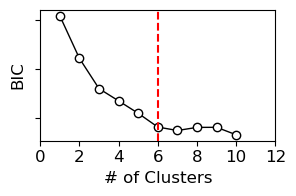

In [48]:
f, arr = plt.subplots()
f.set_size_inches(3., 2.)

arr.plot(np.arange(10) + 1, bic_scores,c='k', marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)
from kneed import KneeLocator

k_elbow = KneeLocator(
  x=np.arange(10)+1, 
  y=bic_scores, 
  curve="convex", 
  direction="decreasing").elbow
arr.axvline(x=k_elbow, color='r', linestyle='--')
# arr.spines['top'].set_visible(False)
# arr.spines['right'].set_visible(False)
arr.set_xlabel('# of Clusters', fontsize=12)
# arr.set_xticks([0,2,4,6,8,9])
# arr.set_xticklabels(arr.get_xticks().astype('int'),fontsize=12)
# Set the tick locations and labels
xticks = arr.get_xticks().astype('int')
arr.set_xticks(xticks)
arr.set_xticklabels(xticks, fontsize=12)
# arr.set_xticklabels(np.arange(10)+1,fontsize=12);
arr.set_ylabel('BIC', fontsize=12)
# arr.set_yticklabels(arr.get_yticks(),fontsize=12)
arr.set_yticklabels([])
f.tight_layout()  # Adjust the layout of the figure
plt.savefig('/moto/home/ch3676/spike_contrastive/notebooks/figures/cell_type/cell_types_cont_bic.pdf', dpi=300)
plt.show()

In [27]:
# f, arr = plt.subplots()
# f.set_size_inches(3., 2.)

# arr.plot(np.arange(10) + 1, aic_scores,c='k', marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)
# from kneed import KneeLocator

# k_elbow = KneeLocator(
#   x=np.arange(10)+1, 
#   y=aic_scores, 
#   curve="convex", 
#   direction="decreasing").elbow
# arr.axvline(x=k_elbow, color='r', linestyle='--')
# # arr.spines['top'].set_visible(False)
# # arr.spines['right'].set_visible(False)
# arr.set_xlabel('# of Clusters', fontsize=12)
# # arr.set_xticks([0,2,4,6,8,9])
# arr.set_xticklabels(arr.get_xticks().astype('int'),fontsize=12)
# # arr.set_xticklabels(np.arange(10)+1,fontsize=12);
# arr.set_ylabel('AIC', fontsize=12)
# arr.set_yticklabels(arr.get_yticks(),fontsize=12);

In [15]:
from sklearn.manifold import TSNE

cont_reps_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=150).fit_transform(cont_reps)

In [16]:
#visualize aug representations in 2D pca
pcs_cont, _, _ = pca(cont_reps, n_comps=2)

In [30]:
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
# cluster_colors = [CUSTOM_PAL_SORT_3[i] for i in labels[5]]
num_clusters = k_elbow
cluster_colors = [CUSTOM_PAL_SORT_3[i] for i in labels[num_clusters-1]]

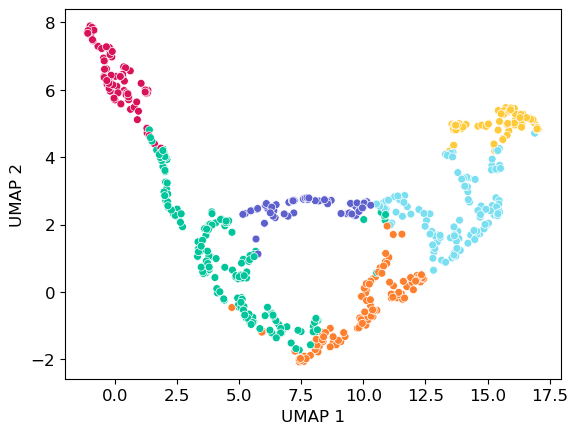

In [31]:
plt.scatter(cont_reps_umap[:,0], cont_reps_umap[:,1], marker='o', c=cluster_colors, s=32, edgecolor='w',linewidth=0.5);
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.savefig('/moto/home/ch3676/spike_contrastive/notebooks/figures/cell_type/cell_types_cont_umap.pdf', dpi=300)
plt.show()

In [32]:
trough_to_peak = np.load('/moto/home/ch3676/spike_contrastive/trough_to_peak.npy')
peak_ratio = np.load('/moto/home/ch3676/spike_contrastive/peak_ratio.npy')
ap_width = np.load('/moto/home/ch3676/spike_contrastive/ap_width.npy')

ap_width_ticks = np.arange(0, np.max(np.round(ap_width,2)+.1), .05)

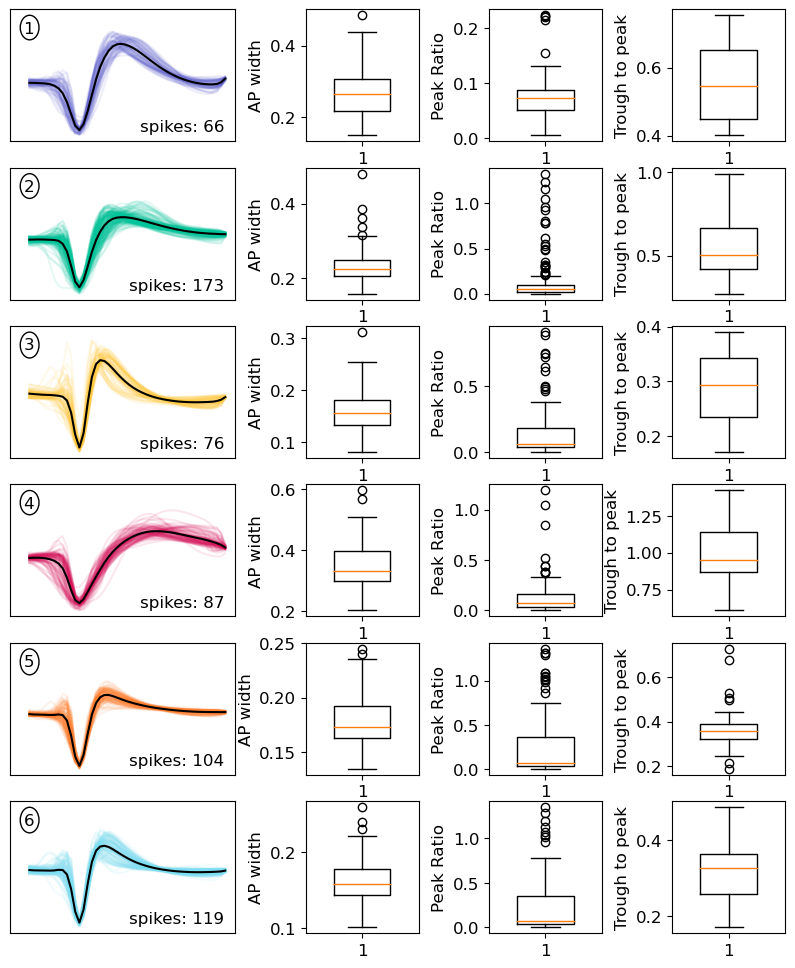

In [39]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

fig = plt.figure(figsize=(10., 12.))
gs = fig.add_gridspec(num_clusters, 4, width_ratios=[1, 0.5, 0.5, 0.5])
cluster_colors_array = np.asarray(cluster_colors)
for unit_id in np.unique(labels[num_clusters-1]):
    ax1 = fig.add_subplot(gs[unit_id, 0])
    ax2 = fig.add_subplot(gs[unit_id, 1])
    ax3 = fig.add_subplot(gs[unit_id, 2])
    ax4 = fig.add_subplot(gs[unit_id, 3])
    

    colors = cluster_colors_array[labels[num_clusters-1] == unit_id]
    for spike in spikes_test_wavemap[labels[num_clusters-1] == unit_id]:
        ax1.plot(spike, alpha=.1, color=colors[0])
    ax1.plot(np.mean(spikes_test_wavemap[labels[num_clusters-1] == unit_id], 0), alpha=1, color='black')
    
    ax1.annotate(f'spikes: {len(spikes_test_wavemap[labels[num_clusters-1] == unit_id])}', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=12)
    circle_text = Ellipse((0.05, 0.95), width=4.5, height=0.5, angle=0, fill=False, color='black')
    ax1.add_patch(circle_text)
    ax1.annotate(f'{unit_id + 1}', (.0835, 0.855), xycoords='axes fraction', ha='center', va='center', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set(xticks=[], yticks=[])
    
    trough_to_peak_unit = trough_to_peak[labels[num_clusters-1] == unit_id]
    peak_ratio_unit = peak_ratio[labels[num_clusters-1] == unit_id]
    ap_width_unit = ap_width[labels[num_clusters-1] == unit_id]
    # ax2.bar(['Trough to peak', 'Peak ratio', 'AP width'], [trough_to_peak_unit, peak_ratio_unit, ap_width_unit], color='blue')
    ax2.boxplot(ap_width_unit, vert=True, widths=0.5)
    ax3.boxplot(peak_ratio_unit, vert=True, widths=0.5)
    ax4.boxplot(trough_to_peak_unit, vert=True, widths=0.5)
    # ax2.set(yticks=ap_width_ticks, fontsize=12)
    ax2.set_ylabel('AP width', fontsize=12)
    ax3.set_ylabel('Peak Ratio', fontsize=12)
    ax4.set_ylabel('Trough to peak', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax3.tick_params(axis='both', which='major', labelsize=12)
    ax4.tick_params(axis='both', which='major', labelsize=12)
    # ax3.set(xticks=[])
    # ax4.set(xticks=[])
    plt.subplots_adjust(wspace=0.5)
plt.savefig('/moto/home/ch3676/spike_contrastive/notebooks/figures/cell_type/cell_types_cont_wfs_full.pdf', dpi=300)
plt.show()

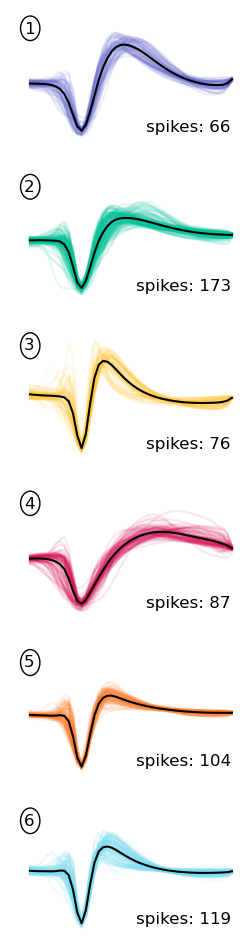

In [40]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
f, axes = plt.subplots(num_clusters,1)
f.set_size_inches(3., 12.)
cluster_colors_array = np.asarray(cluster_colors)
for unit_id in np.unique(labels[num_clusters-1]):
    ax1 = axes[unit_id]
    colors = cluster_colors_array[labels[num_clusters-1] == unit_id]
    for spike in spikes_test_wavemap[labels[num_clusters-1] == unit_id]:
        ax1.plot(spike, alpha=.1, color=colors[0])
    ax1.plot(np.mean(spikes_test_wavemap[labels[num_clusters-1] == unit_id], 0), alpha=1, color='black')
    
    ax1.annotate(f'spikes: {len(spikes_test_wavemap[labels[num_clusters-1] == unit_id])}', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=12)
    circle_text = Ellipse((0.05, 0.95), width=4.5, height=0.5, angle=0, fill=False, color='black')
    ax1.add_patch(circle_text)
    ax1.annotate(f'{unit_id + 1}', (.0835, 0.855), xycoords='axes fraction', ha='center', va='center', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set(xticks=[], yticks=[])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    # plt.subplots_adjust(wspace=0.5)
plt.savefig('/moto/home/ch3676/spike_contrastive/notebooks/figures/cell_type/cell_types_cont_wfs.pdf', dpi=300)
plt.show()

In [22]:
# trough_to_peak = np.load('/moto/home/ch3676/spike_contrastive/trough_to_peak.npy')
# peak_ratio = np.load('/moto/home/ch3676/spike_contrastive/peak_ratio.npy')
# ap_width = np.load('/moto/home/ch3676/spike_contrastive/ap_width.npy')

In [24]:
np.save('/moto/home/ch3676/WaveMAP_Paper/data/cont_reps.npy', cont_reps)
for num_clusters in np.arange(10)+1:
    num_clusters = int(num_clusters)
    np.save(f'/moto/home/ch3676/WaveMAP_Paper/data/cont_labels_gmm_{num_clusters}_nodo.npy', labels[num_clusters-1])

In [394]:
num_clusters = 4
len(set(labels[num_clusters]))

5

In [387]:
len(set(labels[3]))

4

In [385]:
len(labels)

10

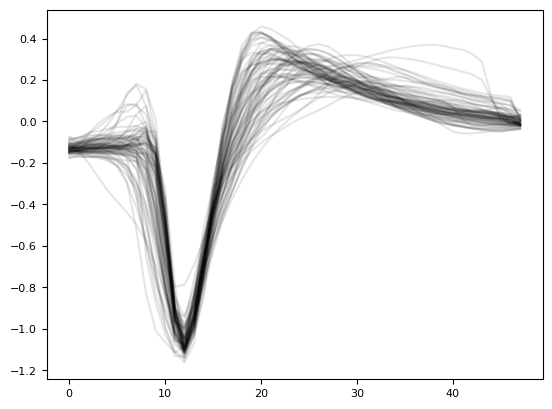

In [179]:
unit_id = 1
for spike in spikes_test_wavemap[gmm_labels==unit_id]:
    plt.plot(spike, alpha=.1, color='black')

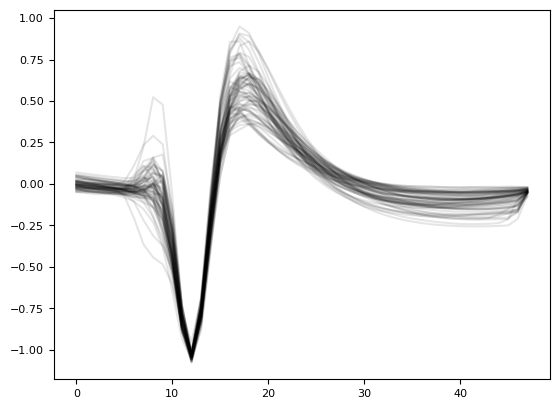

In [180]:
unit_id = 2
for spike in spikes_test_wavemap[gmm_labels==unit_id]:
    plt.plot(spike, alpha=.1, color='black')

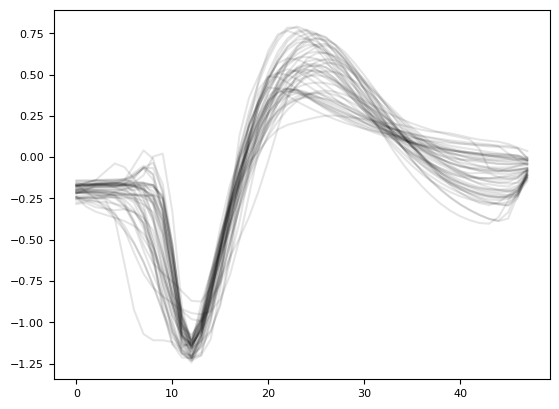

In [181]:
unit_id = 3
for spike in spikes_test_wavemap[gmm_labels==unit_id]:
    plt.plot(spike, alpha=.1, color='black')

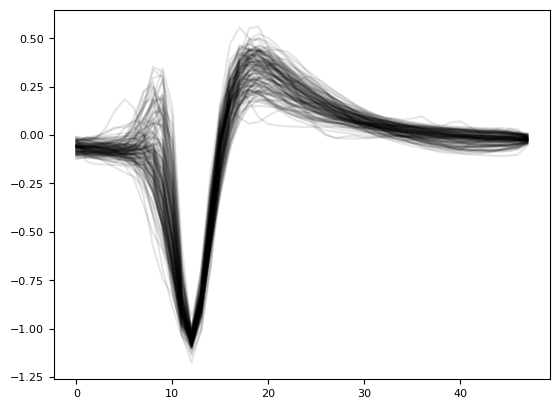

In [182]:
unit_id = 4
for spike in spikes_test_wavemap[gmm_labels==unit_id]:
    plt.plot(spike, alpha=.1, color='black')

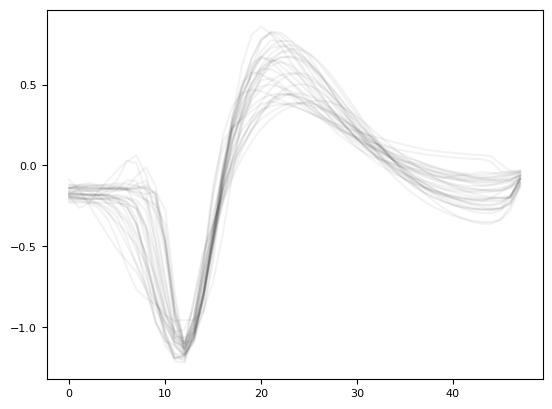

In [183]:
unit_id = 5
for spike in spikes_test_wavemap[gmm_labels==unit_id]:
    plt.plot(spike, alpha=.05, color='black')

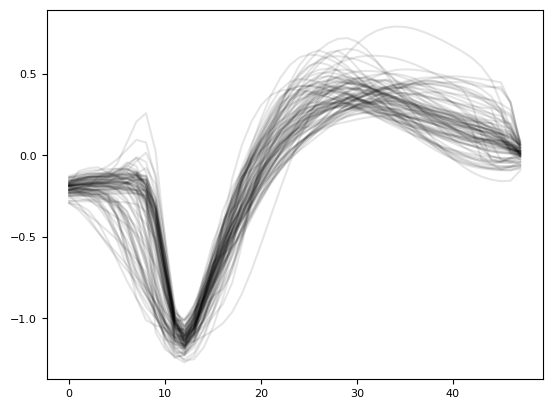

In [184]:
unit_id = 6
for spike in spikes_test_wavemap[gmm_labels==unit_id]:
    plt.plot(spike, alpha=.1, color='black')